# BOSCH - Interview Project

Applicant: Patryk Gadziomski

**Problem:**<br>
We a dataset with three fruittypes. Every fruit is described by its color, wight and size. The problem/task is to build an model, which can classify a fruit by this three features.

**Method:**<br>
To solve this problem/task we use logistic regression to classify all the fruits by they features in grapes, apples or bannanas. For comparison and eventually better results, we'll use desicion tree.

**Results:**<br>
After the data exploration, data preprocessing, model buidling and evaluation the final accuary of the model is by 0.8 or 80%.

The accuary of logistic regression: `0.73`<br>
The accuary of decision tree: `0.8`

From the predictions and metrics of the two models, we can assume that we can't archiev a high accuary with the current state.

An accuracy of 0.8 at the end is not bad, but also not the best and not close enought at out goal. For furhter fine-tuning it should be 'in betracht gezogen' to user different parametrs, other algorithms or model-types or to expend or modify the data.

<div style="width: 100%; height: 30px; background-color:red"></div>

# 0. Importing all Requirements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# 1. Data Exploration

In [2]:
# load the data
fruit_data = pd.read_excel('./data/fruit_data.xlsx')
fruit_data.head()

,Unnamed: 0,fruit_type,color,size,weight
0,0,grape,Yellow,Tiny,8.303385
1,1,apple,Pink,Largee,80.976370
2,2,banana,Pale Yellow,Large,74.615192
3,3,grape,Red,Tiny,6.924070
4,4,banana,Creamy White,Largee,82.002542


After a first look at the data, we can see that the feature `Unnamed: 0` is a representation of the index and can be deleted in further preprocessing steps.

In [3]:
fruit_data['fruit_type'].unique()

array(['grape', 'apple', 'banana'], dtype=object)

In [4]:
fruit_data['color'].unique()

array(['Yellow', 'Pink', 'Pale Yellow', 'Red', 'Creamy White', 'Green',
       'Yellow1', 'Purple', 'Black'], dtype=object)

In [5]:
fruit_data['size'].unique()

array(['Tiny', 'Largee', 'Large', 'Small', 'Medium'], dtype=object)

We also took a look at all the non-numeric values. There we can see that *Yellow1* in `color` and *Largee* in `size` are just typos and need to be fixed in further preprocessing.

In [6]:
fruit_data.describe()

,Unnamed: 0,weight
count,200.000000,200.000000
mean,99.500000,59.047220
std,57.879185,46.697739
min,0.000000,1.000000
25%,49.750000,8.142752
50%,99.500000,63.109415
75%,149.250000,94.367815
max,199.000000,250.000000


Because the `fruit_type', `color' and `size' features are non-numeric, there is no description for these features.

In [7]:
fruit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   fruit_type  200 non-null    object 
 2   color       200 non-null    object 
 3   size        200 non-null    object 
 4   weight      200 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ KB


The `info()`-function shows that `fruit_type`, `color` and `size` are all `object`-type values. For further work they need to be changed to a numeric value like `int` or `float`.

In [8]:
fruit_data.isnull().sum()

Unnamed: 0    0
fruit_type    0
color         0
size          0
weight        0
dtype: int64

After some Data Exploration steps, there are no Missing Values in the data.

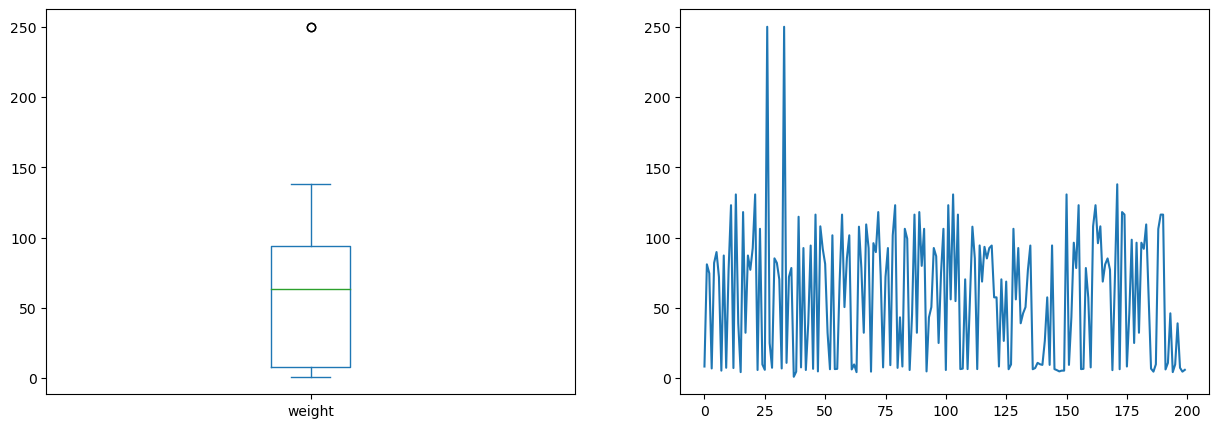

In [9]:
# add label
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df1 = fruit_data['weight']
df2 = fruit_data['weight']

df1.plot.box(ax=axes[0])
df2.plot(ax=axes[1])

plt.show()

In [10]:
fruit_data[fruit_data['weight'] > 200]

,Unnamed: 0,fruit_type,color,size,weight
26,26,apple,Green,Small,250.0
33,33,apple,Yellow,Medium,250.0


After visualizing and printing, we can see that we have two outliers in the feature `weight`.

# 2. Data Preprocessing

The `Unnamed: 0` column is just a representation of the ID and can be omitted.

In [11]:
fruit_data = fruit_data.iloc[:, 1:]
fruit_data

,fruit_type,color,size,weight
0,grape,Yellow,Tiny,8.303385
1,apple,Pink,Largee,80.976370
2,banana,Pale Yellow,Large,74.615192
3,grape,Red,Tiny,6.924070
4,banana,Creamy White,Largee,82.002542
...,...,...,...,...
195,grape,Purple,Small,9.774546
196,banana,Pale Yellow,Large,39.012962
197,grape,Red,Small,7.409021
198,grape,Red,Medium,4.651554


We can see that we have the same colors and sizes multiple times in the data. 
- *Yellow1*
- *Largee*

Something we need to solve before we can turn the data into numerical data.

In [12]:
fruit_data['color'].unique()

array(['Yellow', 'Pink', 'Pale Yellow', 'Red', 'Creamy White', 'Green',
       'Yellow1', 'Purple', 'Black'], dtype=object)

In [13]:
# Yellow1 == Pale Yellow
fruit_data.loc[fruit_data['color'].eq('Yellow1'), 'color'] = 'Yellow'

In [14]:
fruit_data['size'].unique()

array(['Tiny', 'Largee', 'Large', 'Small', 'Medium'], dtype=object)

In [15]:
# Largee == Large
fruit_data.loc[fruit_data['size'].eq('Largee'), 'size'] = 'Large'

After this step, now we only have valid values:

In [16]:
print(fruit_data['color'].unique())
print(fruit_data['size'].unique())

['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Purple'
 'Black']
['Tiny' 'Large' 'Small' 'Medium']


Since we only have two outliers, I decided to remove the rows from our data.

In [17]:
fruit_data = fruit_data.drop([26])
fruit_data = fruit_data.drop([33])

To continue building the model, we need to convert all non-numeric values to numeric values.

In [18]:
fruit_colors = {}
fruit_sizes = {}
fruit_labels = {}

color_num = 0
size_num = 0
label_num = 0

# function to seta numeric value for every non-numeric value in the feature
def change_into_numeric(column, fruit_dict, number):
    for i in fruit_data[column].unique():
        fruit_dict[i] = number
        number += 1

# change the values of color, size and fruit_type
change_into_numeric('color', fruit_colors, color_num)
change_into_numeric('size', fruit_sizes, size_num)
change_into_numeric('fruit_type', fruit_labels, label_num)

print(fruit_colors)
print(fruit_sizes)
print(fruit_labels)

{'Yellow': 0, 'Pink': 1, 'Pale Yellow': 2, 'Red': 3, 'Creamy White': 4, 'Green': 5, 'Purple': 6, 'Black': 7}
{'Tiny': 0, 'Large': 1, 'Small': 2, 'Medium': 3}
{'grape': 0, 'apple': 1, 'banana': 2}


Now we change all the non-numeric values to numeric values.

In [19]:
# exchange the non-numeric values with the numeric values from the dictionaries
def exchange_values(fruit_dict, column):
    for i in fruit_dict:
        fruit_data.loc[fruit_data[column].eq(i), column] = fruit_dict[i]

# exchange th values of color, size and fruit_type
exchange_values(fruit_colors, 'color')
exchange_values(fruit_sizes, 'size')
exchange_values(fruit_labels, 'fruit_type')

fruit_data

,fruit_type,color,size,weight
0,0,0,0,8.303385
1,1,1,1,80.976370
2,2,2,1,74.615192
3,0,3,0,6.924070
4,2,4,1,82.002542
...,...,...,...,...
195,0,6,2,9.774546
196,2,2,1,39.012962
197,0,3,2,7.409021
198,0,3,3,4.651554


Now we gonna cast all the values into `float32`.

In [20]:
fruit_data['color'] = fruit_data['color'].astype('float32')
fruit_data['size'] = fruit_data['size'].astype('float32')
fruit_data['fruit_type'] = fruit_data['fruit_type'].astype('float32')

Let's have a look at the correlations.

<Axes: >

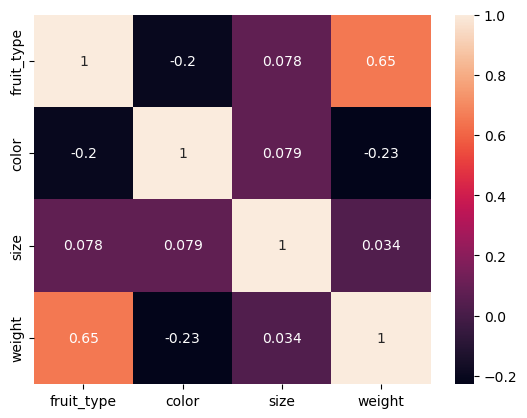

In [21]:
sns.heatmap(fruit_data.corr(), annot=True)

In the correlation matrix we can see that `weight` has a high correlation with `fruit_type`. The influence of `color` on `fruit_type` is ok, but `size` has a really low correlation and so hardly any influence.

Split Data into features and labels

In [22]:
train_split = int(0.8 * len(fruit_data))

train_features = fruit_data.iloc[:train_split, 1:]
train_labels = fruit_data.iloc[:train_split, 0]

test_features = fruit_data.iloc[train_split:, 1:]
test_labels = fruit_data.iloc[train_split:, 0]

In [23]:
# scaler
scaler = StandardScaler()

# scaling the train- and test-features
train_features = pd.DataFrame(scaler.fit_transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(scaler.fit_transform(test_features), columns=test_features.columns)

We also need to scale the data. This puts the numbers on a consistent scale while maintaining the proportional relationship between them.

# 3. Model

## 3.1 Logistic Regression

GridSearchCV makes it easy to find the best parameters for our model.

In [24]:
# Basic model before parameter selection
model = LogisticRegression()

In [25]:
# all the parameter combinations we want to try out
param_grid = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
     'max_iter': [50, 100, 250, 500, 750, 1000]
     }
]

clf = GridSearchCV(model, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1)

# we only take the best model
best_clf = clf.fit(train_features, train_labels)
best_clf.best_estimator_

# Please ignore the error messages. These occur because not 
# every combination is legal.

Fitting 3 folds for each of 840 candidates, totalling 2520 fits


C:\Users\Akira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1134 fits failed out of a total of 2520.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
126 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Akira\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Akira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Akira\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(


LogisticRegression(C=1000, max_iter=50, penalty='l1', solver='liblinear')

After the GridSearchCV we use the folowing parameters:
- solver = `liblinear`
- C = `1000`
- penalty = `l1`
- max_iter = `50`

In [26]:
# Create the model
model = LogisticRegression(solver='liblinear', 
                           C=1000, 
                           penalty='l1', 
                           max_iter=50
                           )

# fit the model on the training data
model.fit(train_features, train_labels)

LogisticRegression(C=1000, max_iter=50, penalty='l1', solver='liblinear')

Now we have to have a look at the metrics and evaluate the model.

In [27]:
# print the score (accuracy) of the model
score = model.score(test_features, test_labels)
print(f'Score: {score}')

# To ensure the model's strenght we also use the cross validated score
scores = cross_val_score(model, train_features, train_labels, cv=5)
print(f'Cross validated score: {np.mean(scores)}')

Score: 0.725
Cross validated score: 0.7211693548387097


In [28]:
# print the coef of the model
fruit_coef = pd.DataFrame(model.coef_, columns = train_features.columns)
fruit_coef

,color,size,weight
0,0.475053,-0.756945,-33.136801
1,-0.110379,-0.023758,1.537243
2,-0.228028,0.217481,0.612185


from the coef output we can see that `weight` has as immense influence of the first class (*grape*).

In [29]:
# predict values with the model
predictions = model.predict(test_features)

# compare the predictions with the actual values
compare_df = pd.DataFrame({'actual': test_labels, 'predicted': predictions})
compare_df

,actual,predicted
160,0.0,0.0
161,1.0,1.0
162,1.0,1.0
163,1.0,1.0
164,1.0,1.0
165,1.0,1.0
166,1.0,2.0
167,1.0,2.0
168,2.0,2.0
169,0.0,0.0


In [30]:
pd.DataFrame(confusion_matrix(test_labels, predictions))

,0,1,2
0,13,0,0
1,1,10,4
2,0,6,6


Using the confusion matrix, we can see that class 0 was predicted correctly every time, while class 1 was predicted correctly 2/3 of the time. Predicting class 2 was a 1/2 chance.

In [31]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       0.62      0.67      0.65        15
         2.0       0.60      0.50      0.55        12

    accuracy                           0.73        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.72      0.72      0.72        40



The classification report shows, that the classifier is good for grapes, but not so good for the two other classes.

## 3.2 Decision Trees

Now we also use a DesicionTreeClassifier for the comparison.

In [32]:
# create the model
dt_model = tree.DecisionTreeClassifier(criterion='gini',        # default
                                 splitter='best',               # default
                                 max_depth=7,                   # 7 gives the best score
                                 min_samples_split=2,           # default
                                 min_samples_leaf=1,            # default
                                 min_weight_fraction_leaf=0.1,  # 0.1 gives the best score
                                 max_features=None,             # default
                                 random_state=None,             # default
                                 max_leaf_nodes=None,           # default
                                 min_impurity_decrease=0.0,     # default
                                 class_weight=None,             # default
                                 ccp_alpha=0.0                  # ddefault
                                 )  

# fit the model on the training data
dt_model.fit(train_features, train_labels)

# Make some predicstions
dt_predictions = dt_model.predict(test_features)

In [33]:
# Score (accuracy) of the dt_model
dt_score = dt_model.score(test_features, test_labels)
print(f'Score: {score}')

# To ensure the model's strenght we also use the cross validated score
dt_scores = cross_val_score(dt_model, train_features, train_labels, cv=10)
print(f'Cross validated score: {np.mean(scores)}')

Score: 0.725
Cross validated score: 0.7211693548387097


In [34]:
# We compare the predictions with the actual values
compare_df = pd.DataFrame({'actual': test_labels, 'predicted': dt_predictions})
compare_df

,actual,predicted
160,0.0,0.0
161,1.0,2.0
162,1.0,1.0
163,1.0,1.0
164,1.0,2.0
165,1.0,2.0
166,1.0,2.0
167,1.0,1.0
168,2.0,2.0
169,0.0,0.0


In [35]:
# We have a look at the confision matrix
print(pd.DataFrame(confusion_matrix(test_labels, dt_predictions)))

    0  1   2
0  13  0   0
1   1  7   7
2   0  0  12


In [36]:
print(classification_report(test_labels, dt_predictions))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       1.00      0.47      0.64        15
         2.0       0.63      1.00      0.77        12

    accuracy                           0.80        40
   macro avg       0.85      0.82      0.79        40
weighted avg       0.87      0.80      0.78        40



We can see that the decision tree has a better accuracy and can predict grapes and bananas without false-prediction. Unfortunately, it predicts apples worse.